# **Household Risk Factors for Multi-Drug Resistance: A Machine Learning Approach in LMIC Contexts**  

## **Abstract**

Antimicrobial resistance (AMR), especially  multidrug resistance (MDR) is a rising global threat, with disproportionate impacts on low- and middle-income countries (LMICs). While most prior work has focused on clinical settings, this study explores **household-level risk factors** for MDR.

Exploratory data analysis highlighted **milk consumption and treatment (boiling)** as well as **consumption of diseased animals** as potential drivers. Initial correlations suggest that MDR status is **positively associated with milk consumption** and **negatively associated with boiling milk**.

A **naive baseline model** (classifying all as MDR) achieved high recall (1.0) but no discriminatory power (ROC AUC = 0.5, PR AUC = 0.53). Our tuned **Logistic Regression model** with threshold adjustment at **t = 0.38** achieved a stronger balance:

* **Precision = 0.757**
* **Recall = 0.863**
* **F₂ = 0.840**
* **Confusion Matrix = \[\[270, 123], \[61, 384]]**

Feature importance and SHAP analysis confirmed that:

1. **Boiling milk** (negative association) and
2. **Milk consumption** (positive association)
   are the most influential predictors, followed by **eating diseased animals**.

These findings suggest that **household milk practices** may play a key role in shaping MDR risks in LMICs, making them a critical target for further surveillance and intervention.

---

## Target
Target Variable: Status of MDR - `mdr` (Binary: Yes/No).  

---

## Introduction
The global emergence of antimicrobial resistance (AMR) is rapidly increasing. Low- and middle-income countries (LMICs) bear a heavy burden of infectious diseases and have limited resources for AMR surveillance and management. The existing research on risk factors has primarily focused on healthcare facilities and clinical contexts, leaving household environments relatively unaddressed. This research can help us better understand the interactions of factors driving AMR in LMICs by examining a wide range of variables.

---

## Stakeholders

* **Primary Stakeholder**

  * **Public health authorities and policymakers in LMICs**
  * Need to understand community-level drivers of antimicrobial resistance (AMR) in order to design effective interventions.

* **Secondary Stakeholder**

  * **Households and communities**
  * Daily practices such as antibiotic and milk consumption, boiling practices, and eating diseased animals influence exposure to multidrug resistance (MDR), directly affecting health outcomes.

---

## Problem Statement

The global emergence of MDR is accelerating, and **LMICs face the heaviest burden** due to high infectious disease rates and limited healthcare infrastructure.

* **Specific & Measurable Problem**: Most existing research has focused on **clinical settings**, while **household-level risk factors remain underexplored**. 


---

## Why This Problem Matters

* **Specific & Measurable Impact**:

  * **False negatives (missed MDR cases)** pose a health risk — individuals and communities continue unsafe practices without awareness.
  * **False positives (misclassified as MDR)** may cause unnecessary fear or misdirected interventions.
  * Understanding household-level drivers of MDR provides a pathway to **design low-cost, community-based interventions** in LMICs where clinical surveillance is limited.
  * Better predictive models help ensure **public health resources are allocated efficiently**.

---

## Project Goal

* **Specific, Measurable, and Achievable Objective**:
Current baseline models (e.g., a “dumb” model that predicts everyone as MDR) achieve **recall = 1.0** but have **no discriminatory power** (ROC AUC = 0.5). We need better models that can identify high-risk individuals while reducing false positives.

  Develop a binary classification model to predict MDR status from household and behavioral variables, with emphasis on:

  * **High recall (≥85%)**: Minimizing false negatives to capture as many true MDR cases as possible.
  * **F₂ score optimization**: Prioritizing recall while keeping precision at a reasonable level.
  * Identifying **key features** (e.g., milk consumption, boiling, diseased animal consumption) to provide **actionable insights** into MDR risk factors.
  

This project ultimately aims to support **data-driven decision-making** for AMR and MDR interventions in LMICs, bridging the gap between household practices and public health strategy.


In [ ]:
# Library
import pandas as pd
import numpy as np
from collections import defaultdict
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import plotly.express as px
from collections import Counter as counter # for counting
%matplotlib inline

# Data Splitting
from sklearn.model_selection import train_test_split

# Feature Engineering
from sklearn.compose import ColumnTransformer, make_column_selector # For preprocessing
from sklearn.pipeline import Pipeline # Making pipelines
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Scale numerical variables
from sklearn.impute import SimpleImputer # Impute missing values
from sklearn.preprocessing import FunctionTransformer # Apply custom functions
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder # Encode categorical variables

# Stats & Utilities
from scipy.stats import randint, kruskal, spearmanr
import statsmodels.api as sm 
import stats
import scipy.stats as stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from xgboost import XGBClassifier # XGBoost
from lightgbm import LGBMClassifier #LightGBM
from catboost import CatBoostClassifier # CatBoost

# Metrics
from sklearn.metrics import make_scorer, accuracy_score, f1_score, fbeta_score, roc_auc_score, roc_curve, classification_report, average_precision_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

# XAI
import shap 
import joblib # For saving models
import pickle

# Warning Suppressions
import warnings
warnings.filterwarnings("ignore")
import time

c:\Users\iamjo\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Understanding & Cleaning

In [2]:
df = pd.read_csv('AMR_data.csv')
display(df.info(), df.describe())

# Check missing values and duplicates
print("\nMissing Values:\n", (df.isnull().sum()))
print("\nMissing Values (pct):\n", (df.isnull().sum()/len(df))*100)
print("\nDuplicates:\n", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              4186 non-null   int64  
 1   id                      4186 non-null   object 
 2   mdr                     4186 non-null   int64  
 3   abruse                  4186 non-null   int64  
 4   boil_milk               4186 non-null   object 
 5   diseased_animals_eaten  4186 non-null   object 
 6   education               4186 non-null   object 
 7   milk_consume            4186 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 261.8+ KB


None

,Unnamed: 0,mdr,abruse,milk_consume
count,4186.000000,4186.000000,4186.000000,4186.000000
mean,2093.500000,0.531295,3.061873,3.857489
std,1208.538442,0.499079,0.874568,2.759098
min,1.000000,0.000000,1.000000,0.000000
25%,1047.250000,0.000000,2.000000,2.000000
50%,2093.500000,1.000000,3.000000,3.000000
75%,3139.750000,1.000000,4.000000,6.000000
max,4186.000000,1.000000,6.000000,10.000000



Missing Values:
 Unnamed: 0                0
id                        0
mdr                       0
abruse                    0
boil_milk                 0
diseased_animals_eaten    0
education                 0
milk_consume              0
dtype: int64

Missing Values (pct):
 Unnamed: 0                0.0
id                        0.0
mdr                       0.0
abruse                    0.0
boil_milk                 0.0
diseased_animals_eaten    0.0
education                 0.0
milk_consume              0.0
dtype: float64

Duplicates:
 0


In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop(columns=['id'], inplace=True)

In [4]:
# Replace 'Yes' with 1 and 'No' with 0 for the specified columns
columns_to_replace = ['boil_milk', 'diseased_animals_eaten', 'education']
df[columns_to_replace] = df[columns_to_replace].replace({'Yes': 1, 'No': 0})

In [5]:
df.head()

,mdr,abruse,boil_milk,diseased_animals_eaten,education,milk_consume
0,1,2,1,1,0,3.0
1,1,2,1,1,0,3.0
2,1,2,1,1,0,3.0
3,0,2,1,1,0,3.0
4,0,2,1,1,0,3.0


# EDA

In [6]:
def info_detail(df):
    # Initialize an empty list to store information about each column
    listItem = []

    # Loop through each column in the DataFrame (df)
    for col in df.columns:
        # Get all unique values in the column, excluding NaN values
        unique_vals = df[col].dropna().unique()

        # Append a list with column information to 'listItem'
        listItem.append([
            col,  # The column name
            df[col].dtype,  # The data type of the column (e.g., int64, float64, object)
            df[col].isna().sum(),  # Count of missing (NaN) values in the column
            round((df[col].isna().sum() / len(df)) * 100, 2),  # Percentage of missing values (NaN)
            df[col].nunique(),  # The number of unique values in the column
            unique_vals  # The actual unique values in the column
        ])

    # Create a DataFrame from the 'listItem' list, providing column names
    df_desc = pd.DataFrame(
        columns=['feature', 'dataType', 'nullCount', 'nullPct', 'uniqueCount', 'UniqueValues'],
        data=listItem
    )

    # Return the DataFrame containing the detailed information about each column
    return df_desc

In [7]:
info_detail(df)

,feature,dataType,nullCount,nullPct,uniqueCount,UniqueValues
0,mdr,int64,0,0.0,2,"[1, 0]"
1,abruse,int64,0,0.0,6,"[2, 3, 5, 6, 4, 1]"
2,boil_milk,int64,0,0.0,2,"[1, 0]"
3,diseased_animals_eaten,int64,0,0.0,2,"[1, 0]"
4,education,int64,0,0.0,2,"[0, 1]"
5,milk_consume,float64,0,0.0,25,"[3.0, 2.5, 2.0, 6.95, 6.0, 5.0, 0.91, 0.06, 0...."


## Categorical
### Based on Total Count of Claims

In [8]:
def plot_mdr(categorical_col):
    mdr_total = df.groupby(categorical_col)['mdr'].count().sort_values()
    sns.barplot(x=mdr_total.index, y=mdr_total.values)
    plt.title(f'MDR by {categorical_col}')
    plt.xlabel(categorical_col, fontsize=5)
    plt.ylabel('mdr', fontsize=8)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


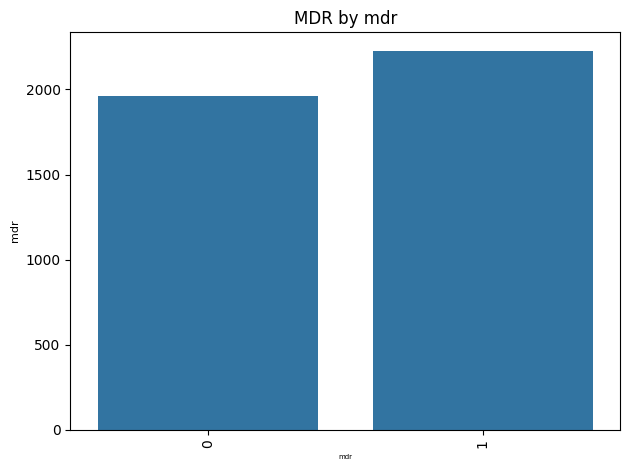

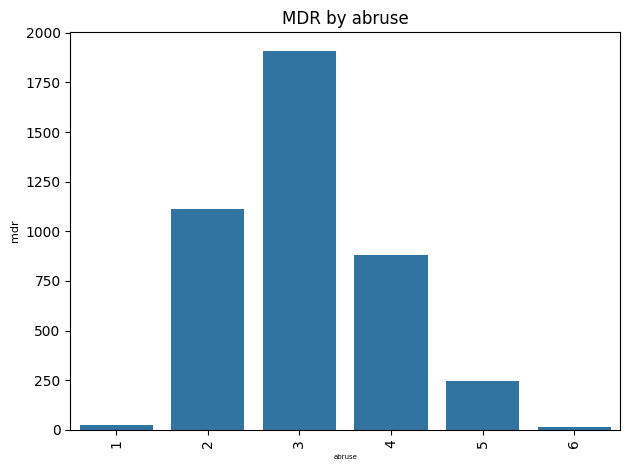

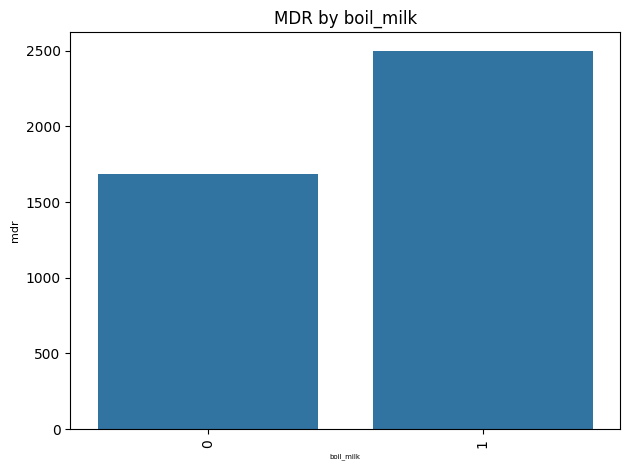

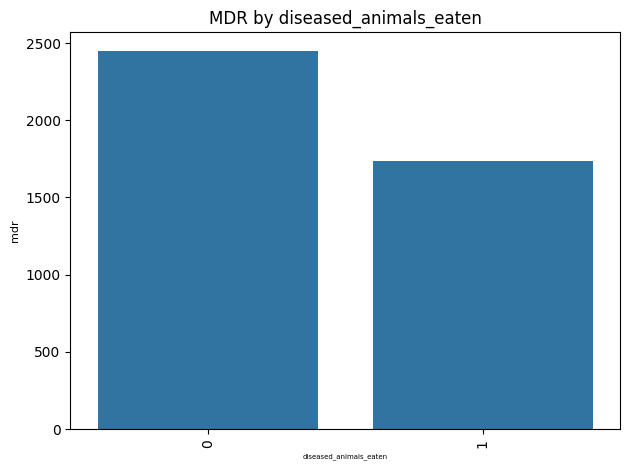

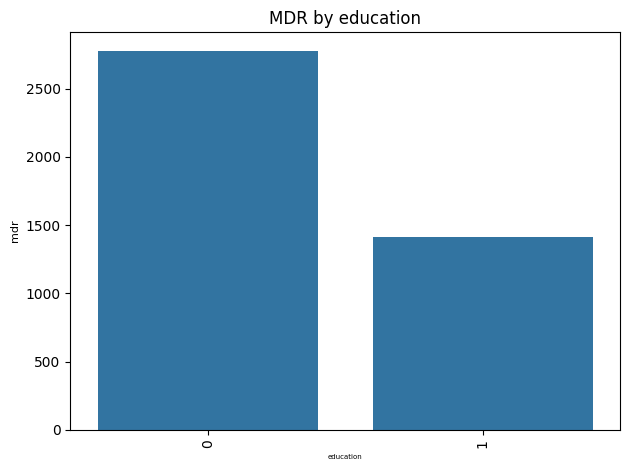

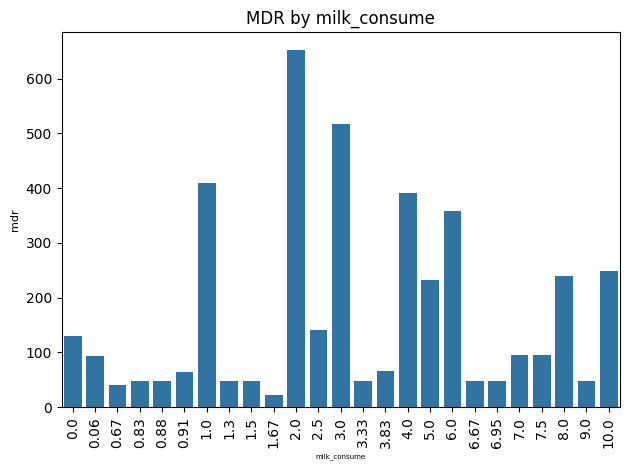

In [9]:
plot_mdr('mdr')
plot_mdr('abruse')
plot_mdr('boil_milk')
plot_mdr('diseased_animals_eaten')
plot_mdr('education')
plot_mdr('milk_consume')

### Based on Proportion of Claims

In [10]:
def plot_mdr_rate(categorical_col):
    mdr_rate = df.groupby(categorical_col)['mdr'].mean().sort_values() * 100
    sns.barplot(x=mdr_rate.index, y=mdr_rate.values)
    plt.title(f'MDR Rate by {categorical_col}')
    plt.xlabel(categorical_col, fontsize=5)
    plt.ylabel('MDR Rate (%)', fontsize=8)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

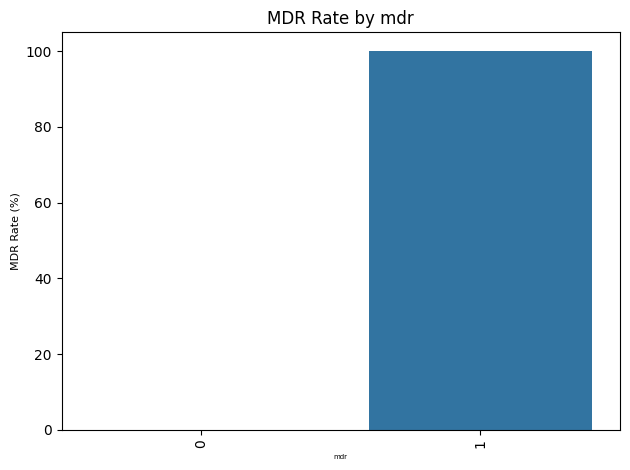

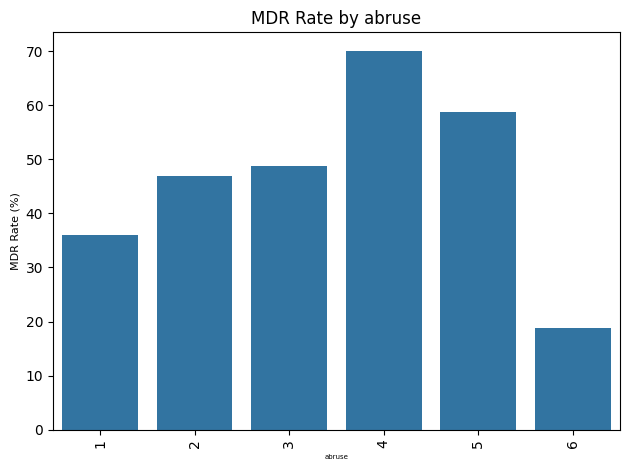

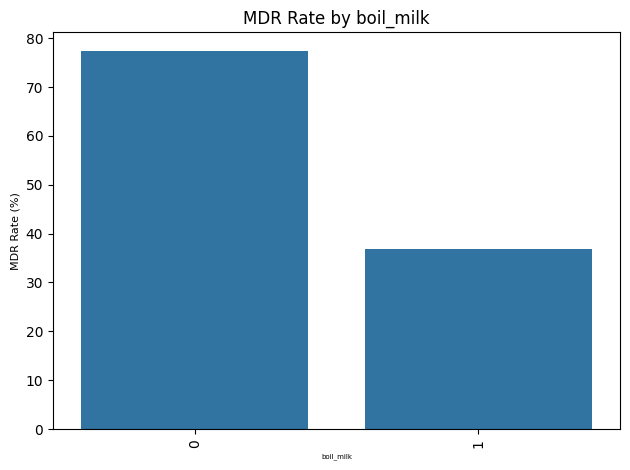

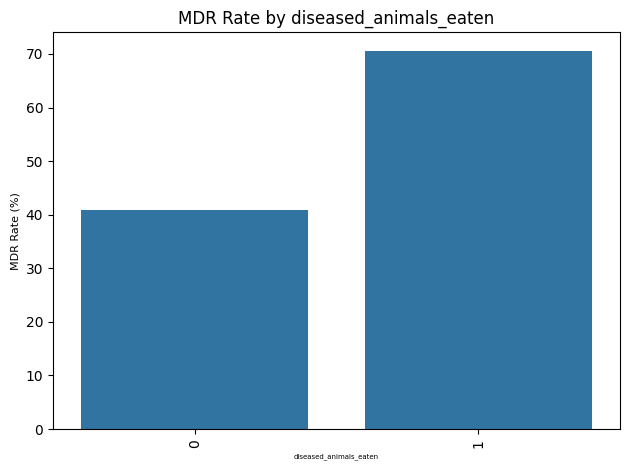

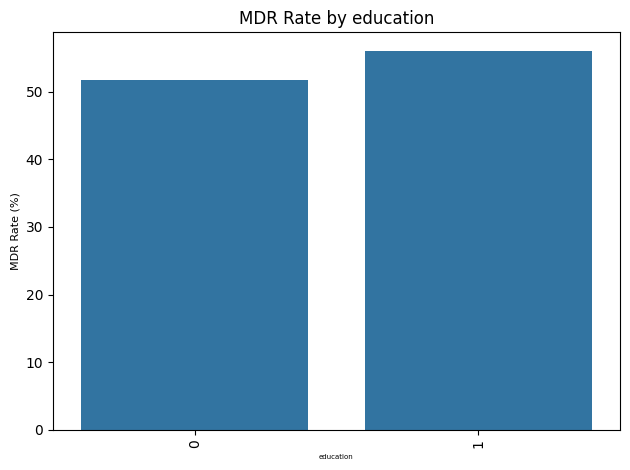

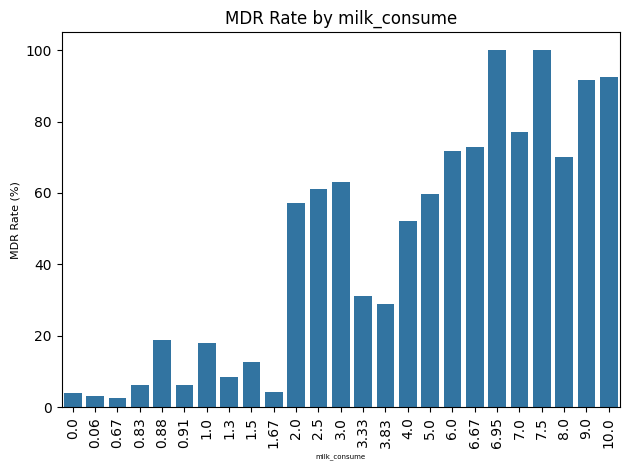

In [11]:
# plotting claim rates for various categorical columns
plot_mdr_rate('mdr')
plot_mdr_rate('abruse')
plot_mdr_rate('boil_milk')
plot_mdr_rate('diseased_animals_eaten')
plot_mdr_rate('education')
plot_mdr_rate('milk_consume')

In [12]:
df.describe()

,mdr,abruse,boil_milk,diseased_animals_eaten,education,milk_consume
count,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000
mean,0.531295,3.061873,0.596512,0.415432,0.337315,3.857489
std,0.499079,0.874568,0.490656,0.492855,0.472850,2.759098
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000
50%,1.000000,3.000000,1.000000,0.000000,0.000000,3.000000
75%,1.000000,4.000000,1.000000,1.000000,1.000000,6.000000
max,1.000000,6.000000,1.000000,1.000000,1.000000,10.000000


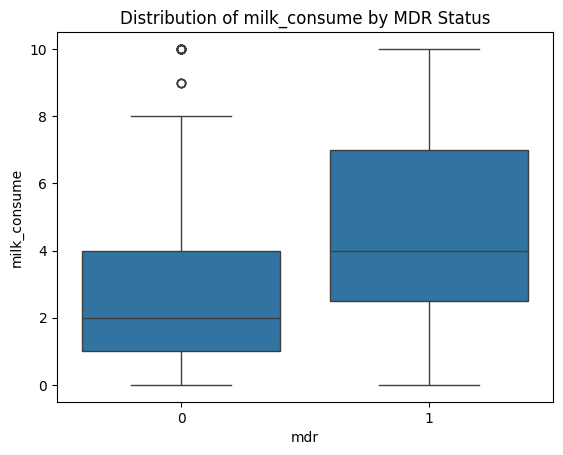

In [13]:
def plot_numerical_distribution(numerical_col):
    sns.boxplot(data=df, x='mdr', y=numerical_col)
    plt.title(f'Distribution of {numerical_col} by MDR Status')
    plt.show()

# Check these columns:
plot_numerical_distribution('milk_consume')

EDA suggests that milk (consumption and treatment) along with eating diseased animals may be the most significant risk factors. Further analyses will be done to see if this is true.

## Correlations

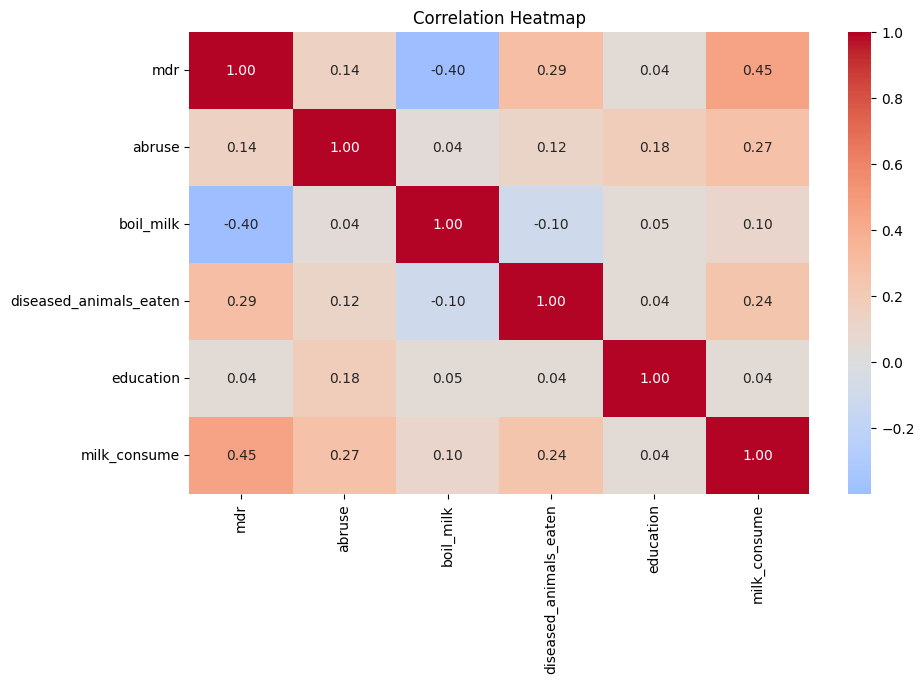

In [14]:
# correlation heatmap of features and target variable
plt.figure(figsize=(10, 6))

# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr(method='spearman')

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

- There seems to be some kind of correlation, although low, between **MDR status and milk consumption**.
- MDR status seems to be **negatively correlated** with whether the **milk is boiled prior to consumption**.

# Milk_consume

In [ ]:
display(df['milk_consume'].value_counts(),
df['milk_consume'].unique())

milk_consume
2.00     652
3.00     518
1.00     410
4.00     392
6.00     358
10.00    249
8.00     240
5.00     233
2.50     141
0.00     130
7.50      96
7.00      96
0.06      94
3.83      66
0.91      64
0.83      48
6.95      48
3.33      48
1.50      48
1.30      48
0.88      48
6.67      48
9.00      48
0.67      40
1.67      23
Name: count, dtype: int64

array([ 3.  ,  2.5 ,  2.  ,  6.95,  6.  ,  5.  ,  0.91,  0.06,  0.83,
        0.88,  1.3 ,  1.  ,  3.83,  0.67, 10.  ,  7.  ,  1.5 ,  9.  ,
        7.5 ,  3.33,  0.  ,  8.  ,  4.  ,  1.67,  6.67])

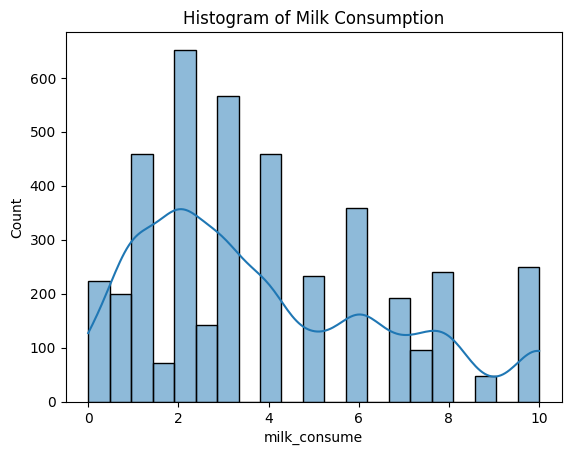

In [ ]:
# Plot histogram
sns.histplot(df['milk_consume'], kde=True)
plt.title('Histogram of Milk Consumption')
plt.show()


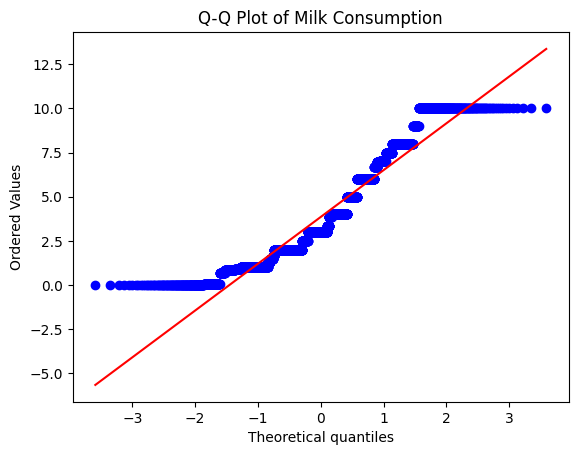

In [ ]:
# Q-Q plot
stats.probplot(df['milk_consume'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Milk Consumption')
plt.show()

In [ ]:
# Shapiro-Wilk test
stat, p_value = stats.shapiro(df['milk_consume'])
print(f"Shapiro-Wilk Test: p-value = {p_value}")

Shapiro-Wilk Test: p-value = 1.054106709932836e-42


In [ ]:
# Check for class imbalance by examining the target class distribution
class_distribution = y.value_counts()
print(f"Class distribution:\n{class_distribution}")

Class distribution:
mdr
1    2224
0    1962
Name: count, dtype: int64


data is not normally distributed

# Modeling

In [15]:
display(df.info(), df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mdr                     4186 non-null   int64  
 1   abruse                  4186 non-null   int64  
 2   boil_milk               4186 non-null   int64  
 3   diseased_animals_eaten  4186 non-null   int64  
 4   education               4186 non-null   int64  
 5   milk_consume            4186 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 196.3 KB


None

,mdr,abruse,boil_milk,diseased_animals_eaten,education,milk_consume
count,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000
mean,0.531295,3.061873,0.596512,0.415432,0.337315,3.857489
std,0.499079,0.874568,0.490656,0.492855,0.472850,2.759098
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000
50%,1.000000,3.000000,1.000000,0.000000,0.000000,3.000000
75%,1.000000,4.000000,1.000000,1.000000,1.000000,6.000000
max,1.000000,6.000000,1.000000,1.000000,1.000000,10.000000


## Defining Features & Target

In [ ]:
# Features
ord_cat = ['abruse']  # Ordinal columns
binary_cols = ['boil_milk', 'diseased_animals_eaten', 'education']  # Binary columns
num_cols = ['milk_consume']  # Continuous column

In [ ]:
# Pipelines for different feature types

# Ordinal Encoding Pipeline (For 'abruse')
ord_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder())  # Automatically encode ordinal values (no predefined categories needed)
])

# Binary Columns (Pass-through, no encoding needed)
binary_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),  # Just impute missing values, if any
    ('passthrough', 'passthrough')  # Pass through the binary columns
])

# Continuous Column (`milk_consume`) - Scaling
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),  # Impute missing values with the median
    ('scaler', StandardScaler())  # Scale continuous features (milk_consume)
])

# Column Transformer: Applying transformations
preprocessor = ColumnTransformer([
    ('ordinal', ord_pipeline, ord_cat),  # Apply ordinal encoding to 'abruse'
    ('binary', binary_pipeline, binary_cols),  # Pass through binary columns as they are
    ('num', num_pipeline, num_cols),  # Scale 'milk_consume'
], remainder='drop')  # Drop any columns not specified (like 'id')

# Intitial pipeline for OLS and VIF
initial_pipeline = Pipeline([
    ('preprocessing', preprocessor),
])

In [ ]:
# Split features and target
X = df.drop(columns='mdr')
y = df['mdr']

## OLS

In [22]:
# Transform features using the 'initial_pipeline'
X_transformed = initial_pipeline.fit_transform(X)

# Retrieve the names of the transformed features
feature_names = initial_pipeline.named_steps['preprocessing'].get_feature_names_out()

# Convert the transformed features into a DataFrame with the original indices and transformed feature names
X_df = pd.DataFrame(X_transformed, columns=feature_names, index=X.index)  # ← index=X.index

# OLS needs intercept
X_const = sm.add_constant(X_df)
# Fit model
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mdr   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     569.0
Date:                Sat, 30 Aug 2025   Prob (F-statistic):               0.00
Time:                        18:13:00   Log-Likelihood:                -1943.4
No. Observations:                4186   AIC:                             3899.
Df Residuals:                    4180   BIC:                             3937.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

### **Key Insights and Takeaways**:

1. **Model Fit**:

   * **R-squared**: The model explains **40.5%** of the variance in `mdr`, showing a **moderate fit**. More room for improvement.
   * **F-statistic** (569.0) and **p-value** (0.00) confirm that the model is **statistically significant**.

2. **Key Predictors**:

   * **`milk_consume`**: Each 1-liter increase increases `mdr` by **0.2226 units** (p-value = 0.000).
   * **`boil_milk`**: Boiling milk **reduces `mdr`** by **0.4396 units** (p-value = 0.000).
   * **`diseased_animals_eaten`**: Positive relationship with `mdr` (+0.1389, p-value = 0.000).
   * **`education`**: Slight positive effect (+0.0594), with **marginal significance** (p-value = 0.000).
   * **`abruse`**: Not significant (p-value = 0.150), suggesting minimal effect on `mdr`.

3. **Residuals**:

   * **Non-normal** residuals and mild **positive autocorrelation** indicate that the model may miss some structure.
   * **Skew** (0.166) and **Kurtosis** (2.353) show slight deviations from normality.

4. **Is the Data Linear?**:

   * The model captures **some linear relationships**, but the **moderate R-squared** and **non-normal residuals** suggest that the data may have **non-linear components** that the model isn't fully capturing.
   * The data is **partially linear**, and non-linear models might better capture these relationships.


## VIF

In [23]:
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric columns for VIF calculation
X_numeric = X.select_dtypes(include=[np.number])

# Add constant for intercept
X_numeric = add_constant(X_numeric)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)


                  Feature        VIF
0                   const  14.773963
1                  abruse   1.143517
2               boil_milk   1.031323
3  diseased_animals_eaten   1.094666
4               education   1.047004
5            milk_consume   1.171519


VIF was done to make sure there are no multicollinearity

In [24]:
# Train-Test Split
X = df.drop(columns=['mdr'], errors='ignore')
y = df['mdr']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Baseline Naive Model

In [ ]:
# Find the majority class in the training data
majority_class = y_train.mode()[0]

# Predict the majority class for both training and testing
y_train_pred_baseline = np.full_like(y_train, majority_class)
y_test_pred_baseline = np.full_like(y_test, majority_class)

In [ ]:
# Confusion Matrix for Dumb Baseline
cm_baseline = confusion_matrix(y_test, y_test_pred_baseline)
tn, fp, fn, tp = cm_baseline.ravel()

# Metrics for Dumb Baseline
baseline_results = {
    'train_accuracy': (y_train_pred_baseline == y_train).mean(),
    'test_accuracy': (y_test_pred_baseline == y_test).mean(),
    'precision': precision_score(y_test, y_test_pred_baseline),
    'recall': recall_score(y_test, y_test_pred_baseline),
    'f1': f1_score(y_test, y_test_pred_baseline),
    'f2': fbeta_score(y_test, y_test_pred_baseline, beta=2),
    'roc_auc': roc_auc_score(y_test, y_test_pred_baseline),
    'pr_auc': average_precision_score(y_test, y_test_pred_baseline),
    'CM': cm_baseline
}

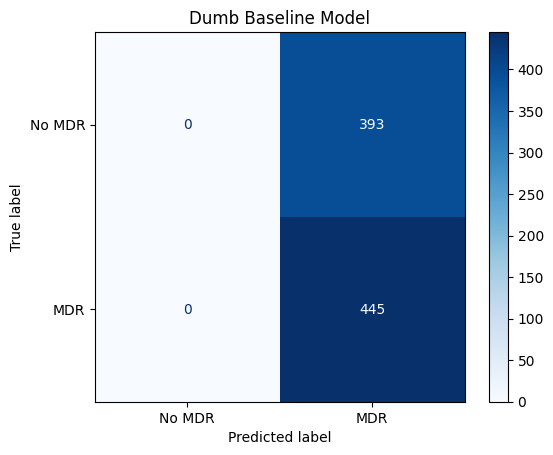

Dumb Baseline Model - Train Accuracy: 0.5314
Dumb Baseline Model - Test Accuracy: 0.5310
Dumb Baseline Model - F1 Score: 0.6937
Dumb Baseline Model - F2 Score: 0.8499
Dumb Baseline Model - Precision: 0.5310
Dumb Baseline Model - Recall: 1.0000
Dumb Baseline Model - ROC AUC: 0.5000
Dumb Baseline Model - PR AUC: 0.5310
Confusion Matrix for Dumb Baseline:
[[  0 393]
 [  0 445]]


In [ ]:
# Display baseline confusion matrix plot
disp = ConfusionMatrixDisplay(cm_baseline, display_labels=['No MDR', 'MDR'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Dumb Baseline Model")
plt.show()

# Print Baseline Metrics
print(f"Dumb Baseline Model - Train Accuracy: {baseline_results['train_accuracy']:.4f}")
print(f"Dumb Baseline Model - Test Accuracy: {baseline_results['test_accuracy']:.4f}")
print(f"Dumb Baseline Model - F1 Score: {baseline_results['f1']:.4f}")
print(f"Dumb Baseline Model - F2 Score: {baseline_results['f2']:.4f}")
print(f"Dumb Baseline Model - Precision: {baseline_results['precision']:.4f}")
print(f"Dumb Baseline Model - Recall: {baseline_results['recall']:.4f}")
print(f"Dumb Baseline Model - ROC AUC: {baseline_results['roc_auc']:.4f}")
print(f"Dumb Baseline Model - PR AUC: {baseline_results['pr_auc']:.4f}")

# Display confusion matrix and metrics
print(f"Confusion Matrix for Dumb Baseline:\n{cm_baseline}")

Our model must perform better than the naive models

## No Gridsearch (Default Baseline)

In [27]:
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

In [28]:
# Make sure the folder exists
os.makedirs("saved_models", exist_ok=True)

# Results and best models
results_nogrid = {}
best_models_nogrid = {}


Training Logistic Regression...


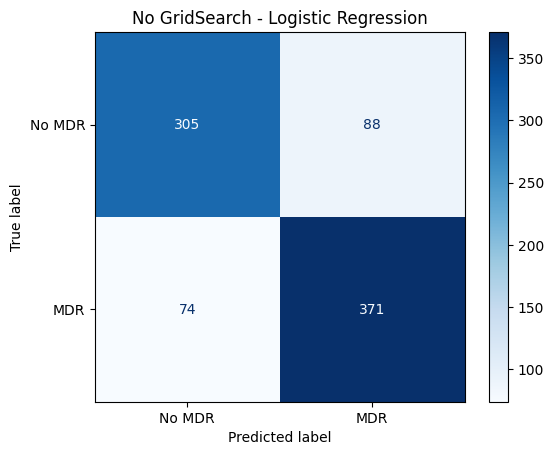


Logistic Regression - Training Accuracy: 0.8068
Logistic Regression - Testing Accuracy: 0.8067
Logistic Regression - Training F2: 0.8191
Logistic Regression - Testing F2: 0.8285
Logistic Regression - Training Time: 0.03 seconds

Training Decision Tree...


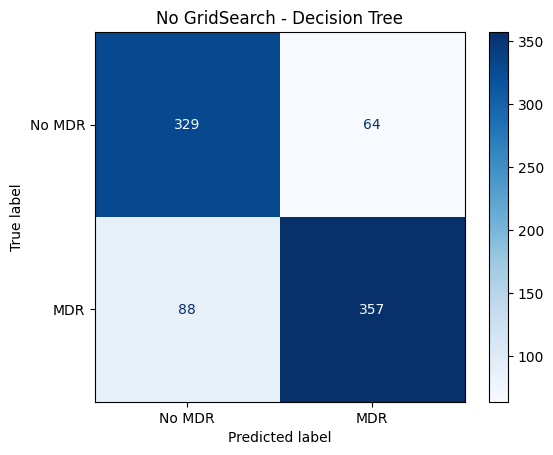


Decision Tree - Training Accuracy: 0.8196
Decision Tree - Testing Accuracy: 0.8186
Decision Tree - Training F2: 0.8008
Decision Tree - Testing F2: 0.8110
Decision Tree - Training Time: 0.02 seconds

Training Random Forest...


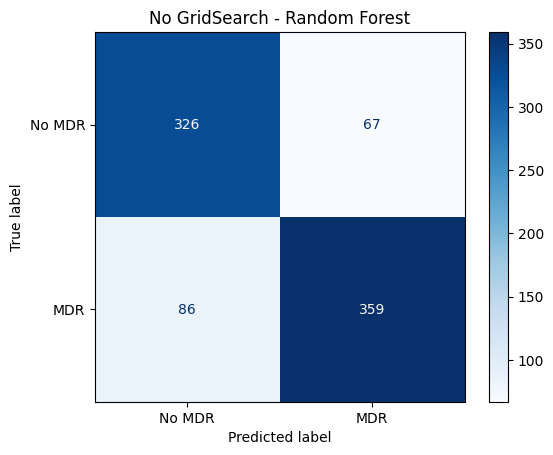


Random Forest - Training Accuracy: 0.8196
Random Forest - Testing Accuracy: 0.8174
Random Forest - Training F2: 0.8012
Random Forest - Testing F2: 0.8137
Random Forest - Training Time: 0.33 seconds

Training XGBoost...


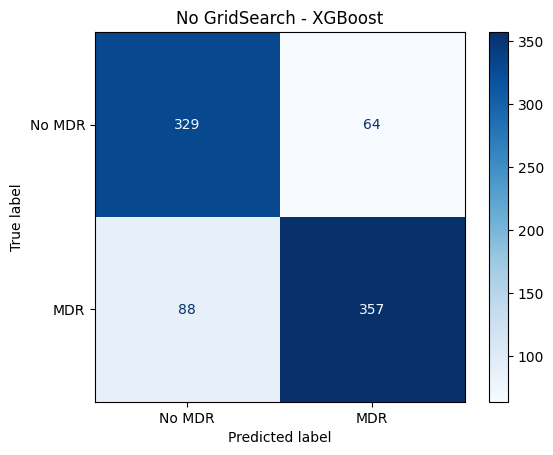


XGBoost - Training Accuracy: 0.8196
XGBoost - Testing Accuracy: 0.8186
XGBoost - Training F2: 0.8008
XGBoost - Testing F2: 0.8110
XGBoost - Training Time: 0.20 seconds

Training LightGBM...
[LightGBM] [Info] Number of positive: 1779, number of negative: 1569
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 3348, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531362 -> initscore=0.125613
[LightGBM] [Info] Start training from score 0.125613


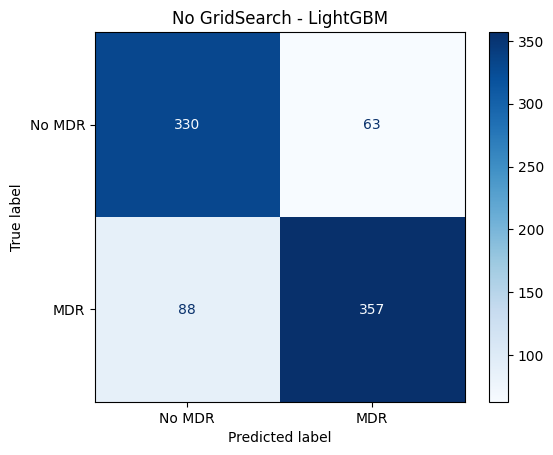


LightGBM - Training Accuracy: 0.8193
LightGBM - Testing Accuracy: 0.8198
LightGBM - Training F2: 0.8003
LightGBM - Testing F2: 0.8114
LightGBM - Training Time: 1.70 seconds

Training CatBoost...


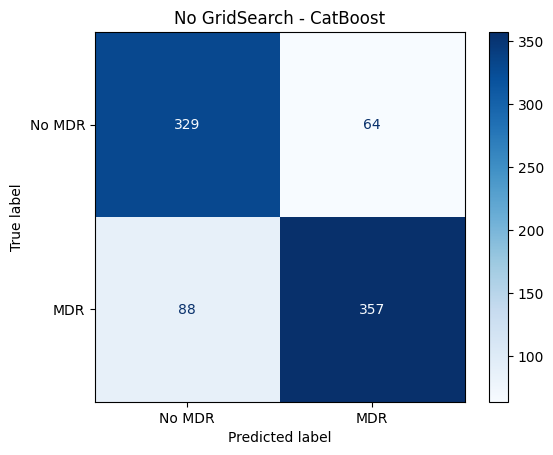


CatBoost - Training Accuracy: 0.8196
CatBoost - Testing Accuracy: 0.8186
CatBoost - Training F2: 0.8008
CatBoost - Testing F2: 0.8110
CatBoost - Training Time: 2.32 seconds


In [29]:
import time

# Loop through each model in the pipeline
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Track runtime
    start_time = time.time()
    
    # Create pipeline with preprocessing and model
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('clf', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Track runtime
    end_time = time.time()
    runtime = end_time - start_time
    
    # Predict and get probabilities
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Confusion matrix and cost calculation
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics
    results_nogrid[name] = {
        'train_accuracy': pipeline.score(X_train, y_train),
        'test_accuracy': pipeline.score(X_test, y_test),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'f2': fbeta_score(y_test, y_test_pred, beta=2),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'pr_auc': average_precision_score(y_test, y_proba),
        'CM': cm,
        'train_f1': f1_score(y_train, y_train_pred),  # Training F1 Score
        'test_f1': f1_score(y_test, y_test_pred),    # Testing F1 Score
        'train_f2': fbeta_score(y_train, y_train_pred, beta=2),  # Training F2 Score
        'test_f2': fbeta_score(y_test, y_test_pred, beta=2),    # Testing F2 Score
        'runtime': runtime  # Save runtime
    }

    # Save best models based on F2 score
    best_models_nogrid[name] = pipeline
    joblib.dump(pipeline, f"saved_models/{name}_nogrid.pkl")

    # Display confusion matrix plot
    disp = ConfusionMatrixDisplay(cm, display_labels=['No MDR', 'MDR'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"No GridSearch - {name}")
    plt.show()

    # Display training and testing metrics for overfitting check
    print(f"\n{name} - Training Accuracy: {results_nogrid[name]['train_accuracy']:.4f}")
    print(f"{name} - Testing Accuracy: {results_nogrid[name]['test_accuracy']:.4f}")
    print(f"{name} - Training F2: {results_nogrid[name]['train_f2']:.4f}")
    print(f"{name} - Testing F2: {results_nogrid[name]['test_f2']:.4f}")
    
    # Runtime for model training
    print(f"{name} - Training Time: {runtime:.2f} seconds")

In [30]:
# Save results as data frame to CSV sorted by F2 score
results_df_nogrid = pd.DataFrame(results_nogrid).T.sort_values(by='f2', ascending=False)
results_df_nogrid.to_csv("saved_models/results_nogrid.csv")

# Optionally, print results to see the sorted F2 score
print("\nResults sorted by F2 score:")
print(results_df_nogrid)


Results sorted by F2 score:
                    train_accuracy test_accuracy precision    recall  \
Logistic Regression        0.80675      0.806683  0.808279  0.833708   
Random Forest             0.819594      0.817422  0.842723  0.806742   
LightGBM                  0.819295      0.819809      0.85  0.802247   
Decision Tree             0.819594      0.818616  0.847981  0.802247   
XGBoost                   0.819594      0.818616  0.847981  0.802247   
CatBoost                  0.819594      0.818616  0.847981  0.802247   

                           f1        f2   roc_auc    pr_auc  \
Logistic Regression  0.820796  0.828495    0.8746  0.892724   
Random Forest         0.82434   0.81369  0.890337  0.906569   
LightGBM             0.825434  0.811364  0.890983  0.910873   
Decision Tree         0.82448  0.810995  0.888853  0.902865   
XGBoost               0.82448  0.810995  0.890468  0.910268   
CatBoost              0.82448  0.810995  0.890622  0.910724   

                        

From these results, **Logistic Regression achieved the best F₂ score (0.828)**, making it the strongest model for minimizing false negatives, while Random Forest, LightGBM, and others performed similarly but with slightly lower recall-focused balance. Overall, simpler models like Logistic Regression not only performed best but also ran faster and remained easier to interpret.

## GridSearch F2

In [31]:
# Create custom F2 scorer (for beta=2)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l1','l2']
    },
    'Decision Tree': {
        'clf__max_depth': [5, 10, 20],
        'clf__min_samples_split': [2, 5],
        'clf__criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [10, 20, None],
        'clf__min_samples_split': [2, 5],
    },
    'XGBoost': {
        'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'clf__n_estimators': [100, 150, 200],
        'clf__max_depth': [10, 20, 50],
        'clf__subsample': [0.8, 1.0, 1.5]
    },
    'LightGBM': {
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [5, 10, 20],
        'clf__subsample': [0.8, 1.0]
    },
    'CatBoost': {
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__iterations': [50, 100, 200],
        'clf__depth': [3, 6, 10],
    }
}

In [32]:
results_gridF2 = {}
best_models_gridF2 = {}


Training Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


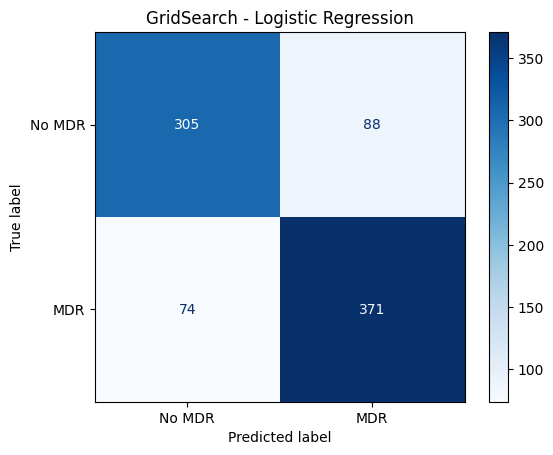


Logistic Regression - Training Accuracy: 0.8068
Logistic Regression - Testing Accuracy: 0.8067
Logistic Regression - Training F2: 0.8191
Logistic Regression - Testing F2: 0.8285
Logistic Regression - Best Params: {'clf__C': 0.1, 'clf__penalty': 'l1'}
Logistic Regression - Training Time: 3.04 seconds

Training Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


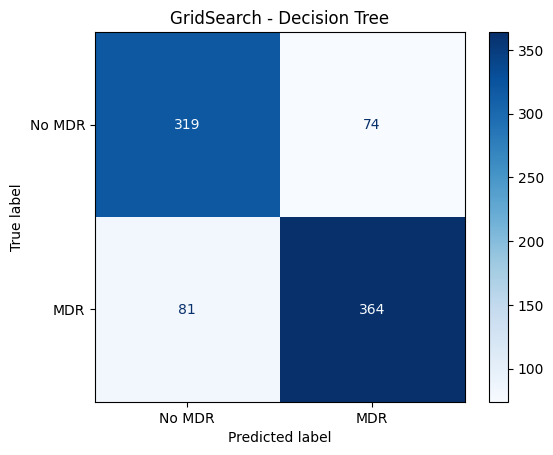


Decision Tree - Training Accuracy: 0.8145
Decision Tree - Testing Accuracy: 0.8150
Decision Tree - Training F2: 0.8108
Decision Tree - Testing F2: 0.8206
Decision Tree - Best Params: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_split': 2}
Decision Tree - Training Time: 0.39 seconds

Training Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


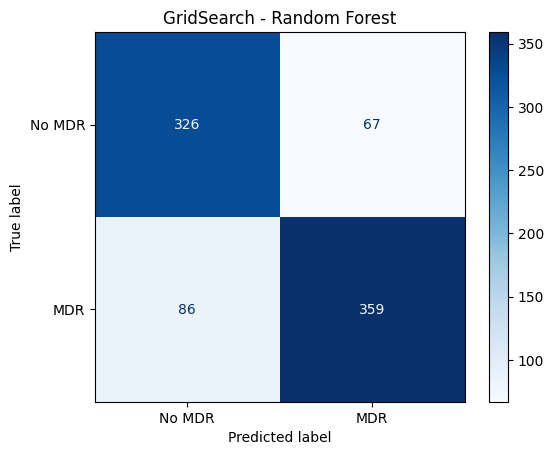


Random Forest - Training Accuracy: 0.8196
Random Forest - Testing Accuracy: 0.8174
Random Forest - Training F2: 0.8012
Random Forest - Testing F2: 0.8137
Random Forest - Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Random Forest - Training Time: 3.56 seconds

Training XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


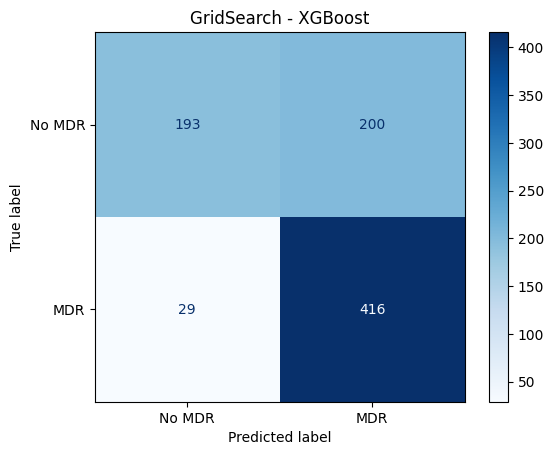


XGBoost - Training Accuracy: 0.7602
XGBoost - Testing Accuracy: 0.7267
XGBoost - Training F2: 0.8879
XGBoost - Testing F2: 0.8681
XGBoost - Best Params: {'clf__learning_rate': 0.001, 'clf__max_depth': 10, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
XGBoost - Training Time: 7.00 seconds

Training LightGBM...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Number of positive: 1779, number of negative: 1569
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 3348, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531362 -> initscore=0.125613
[LightGBM] [Info] Start training from score 0.125613


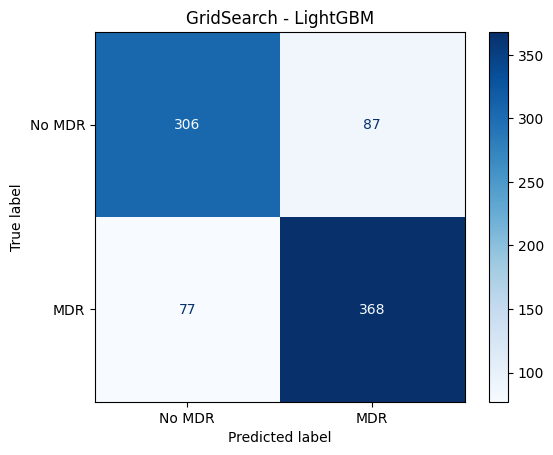


LightGBM - Training Accuracy: 0.8175
LightGBM - Testing Accuracy: 0.8043
LightGBM - Training F2: 0.8285
LightGBM - Testing F2: 0.8233
LightGBM - Best Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 10, 'clf__n_estimators': 50, 'clf__subsample': 0.8}
LightGBM - Training Time: 14.57 seconds

Training CatBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


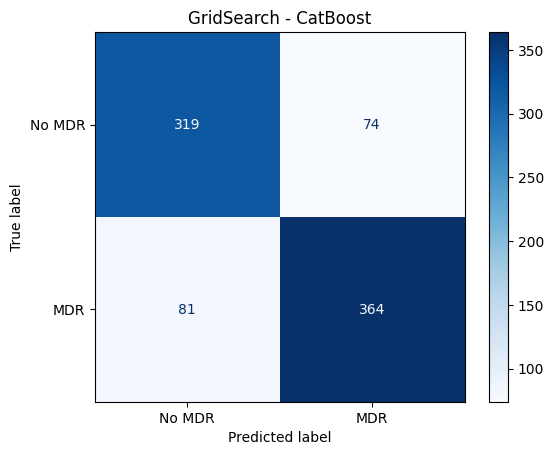


CatBoost - Training Accuracy: 0.8145
CatBoost - Testing Accuracy: 0.8150
CatBoost - Training F2: 0.8108
CatBoost - Testing F2: 0.8206
CatBoost - Best Params: {'clf__depth': 3, 'clf__iterations': 50, 'clf__learning_rate': 0.01}
CatBoost - Training Time: 10.02 seconds


In [33]:
# Loop through each model and perform GridSearchCV
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Create the pipeline
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('clf', model)
    ])
    
    # Create GridSearchCV with the custom F2 scorer
    grid_search = GridSearchCV(pipeline, param_grid=param_grids[name], scoring=f2_scorer, cv=5, n_jobs=-1, verbose=1)
    
    # Track runtime
    start_time = time.time()
    
    # Fit the model with GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Track runtime
    end_time = time.time()
    runtime = end_time - start_time
    
    # Get the best model from GridSearchCV
    best_pipeline = grid_search.best_estimator_
    
    # Predict and get probabilities
    y_train_pred = best_pipeline.predict(X_train)
    y_test_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]

    # Confusion matrix and cost calculation
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics
    results_gridF2[name] = {
        'train_accuracy': best_pipeline.score(X_train, y_train),
        'test_accuracy': best_pipeline.score(X_test, y_test),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'f2': fbeta_score(y_test, y_test_pred, beta=2),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'pr_auc': average_precision_score(y_test, y_proba),
        'CM': cm,
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'train_f2': fbeta_score(y_train, y_train_pred, beta=2),
        'test_f2': fbeta_score(y_test, y_test_pred, beta=2),
        'runtime': runtime,
        'best_params': grid_search.best_params_  # Save best hyperparameters
    }

    # Save the best model
    best_models_gridF2[name] = best_pipeline
    joblib.dump(best_pipeline, f"saved_models/{name}_gridsearch_f2.pkl")

    # Display confusion matrix plot
    disp = ConfusionMatrixDisplay(cm, display_labels=['No MDR', 'MDR'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"GridSearch - {name}")
    plt.show()

    # Display metrics
    print(f"\n{name} - Training Accuracy: {results_gridF2[name]['train_accuracy']:.4f}")
    print(f"{name} - Testing Accuracy: {results_gridF2[name]['test_accuracy']:.4f}")
    print(f"{name} - Training F2: {results_gridF2[name]['train_f2']:.4f}")
    print(f"{name} - Testing F2: {results_gridF2[name]['test_f2']:.4f}")
    print(f"{name} - Best Params: {results_gridF2[name]['best_params']}")
    
    # Runtime for model training
    print(f"{name} - Training Time: {runtime:.2f} seconds")

In [34]:
# Save results as a DataFrame to CSV sorted by F2 score
results_gridF2_df = pd.DataFrame(results_gridF2).T.sort_values(by='test_f2', ascending=False)
results_gridF2_df.to_csv("saved_models/results_gridF2.csv")

# Optionally, print results to see the sorted F2 score
print("\nResults sorted by F2 score:")
print(results_gridF2_df)


Results sorted by F2 score:
                    train_accuracy test_accuracy precision    recall  \
XGBoost                   0.760155       0.72673  0.675325  0.934831   
Logistic Regression        0.80675      0.806683  0.808279  0.833708   
LightGBM                  0.817503      0.804296  0.808791  0.826966   
Decision Tree             0.814516      0.815036   0.83105  0.817978   
CatBoost                  0.814516      0.815036   0.83105  0.817978   
Random Forest             0.819594      0.817422  0.842723  0.806742   

                           f1        f2   roc_auc    pr_auc  \
XGBoost              0.784166  0.868114  0.887772  0.900258   
Logistic Regression  0.820796  0.828495  0.874698  0.892959   
LightGBM             0.817778  0.823266  0.890408  0.908557   
Decision Tree        0.824462  0.820559  0.881611  0.897874   
CatBoost             0.824462  0.820559   0.87577  0.901059   
Random Forest         0.82434   0.81369  0.890342  0.906123   

                        

From these results, **XGBoost achieved the highest F₂ score (0.868)**, making it the best at minimizing false negatives, though it came with lower precision and higher runtime. **Logistic Regression** followed with a strong balance of recall, precision, and efficiency, while LightGBM, Decision Tree, CatBoost, and Random Forest performed similarly but with slightly lower F₂ scores.

## GridSearch Recall

In [35]:
# Define parameter grids for each model
recall_grids = {
    'Logistic Regression': {
        'clf__C': [0.001, 0.01, 0.1],
        'clf__penalty': ['l1','l2']
    },
    'Decision Tree': {
        'clf__max_depth': [5, 10, 20],
        'clf__min_samples_split': [2, 5],
        'clf__criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [10, 20, None],
        'clf__min_samples_split': [2, 5],
    },
    'XGBoost': {
        'clf__learning_rate': [0.01, 0.05, 0.1],   
        'clf__n_estimators': [100, 200, 500, 1000],
        'clf__max_depth': [3, 5, 7, 10],
        'clf__subsample': [0.1, 0.5, 0.8, 1.0, 1.2]
    },
    'LightGBM': {
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [5, 10, 20],
        'clf__subsample': [0.8, 1.0]
    },
    'CatBoost': {
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__iterations': [50, 100, 200],
        'clf__depth': [3, 6, 10],
    }
}

In [36]:
results_gridrecall = {}
best_models_gridrecall = {}


Training Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


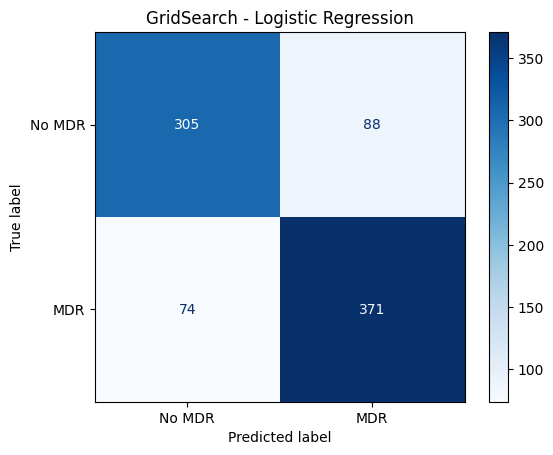


Logistic Regression - Training Accuracy: 0.8068
Logistic Regression - Testing Accuracy: 0.8067
Logistic Regression - Training F2: 0.8191
Logistic Regression - Testing F2: 0.8285
Logistic Regression - Best Params: {'clf__C': 0.1, 'clf__penalty': 'l1'}
Logistic Regression - Training Time: 0.20 seconds
Logistic Regression - Training Time: 0.20 seconds

Training Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


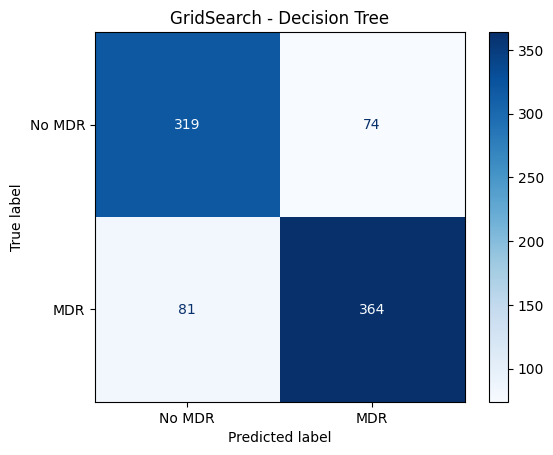


Decision Tree - Training Accuracy: 0.8145
Decision Tree - Testing Accuracy: 0.8150
Decision Tree - Training F2: 0.8108
Decision Tree - Testing F2: 0.8206
Decision Tree - Best Params: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_split': 2}
Decision Tree - Training Time: 0.35 seconds
Decision Tree - Training Time: 0.35 seconds

Training Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


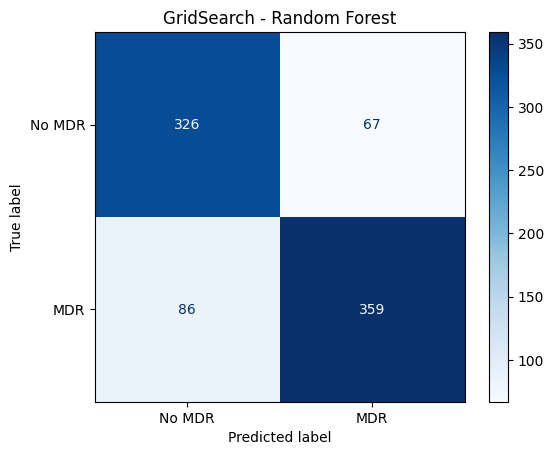


Random Forest - Training Accuracy: 0.8196
Random Forest - Testing Accuracy: 0.8174
Random Forest - Training F2: 0.8012
Random Forest - Testing F2: 0.8137
Random Forest - Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Random Forest - Training Time: 4.40 seconds
Random Forest - Training Time: 4.40 seconds

Training XGBoost...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


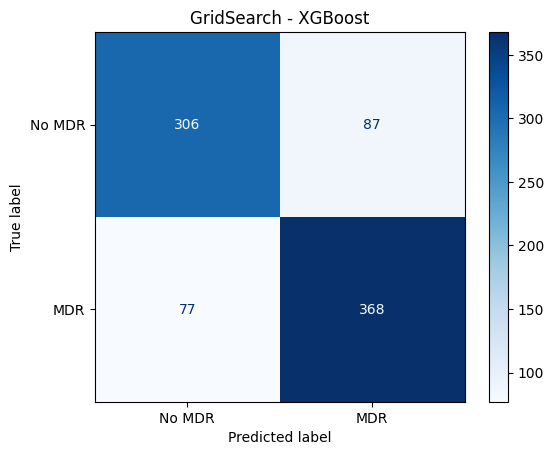


XGBoost - Training Accuracy: 0.8175
XGBoost - Testing Accuracy: 0.8043
XGBoost - Training F2: 0.8285
XGBoost - Testing F2: 0.8233
XGBoost - Best Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 10, 'clf__n_estimators': 100, 'clf__subsample': 0.5}
XGBoost - Training Time: 31.47 seconds
XGBoost - Training Time: 31.47 seconds

Training LightGBM...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Number of positive: 1779, number of negative: 1569
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 3348, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531362 -> initscore=0.125613
[LightGBM] [Info] Start training from score 0.125613


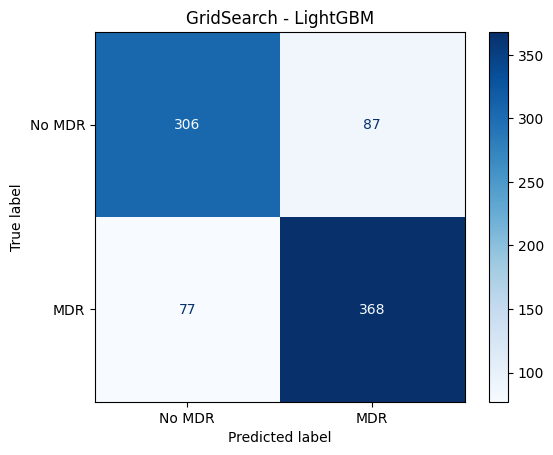


LightGBM - Training Accuracy: 0.8175
LightGBM - Testing Accuracy: 0.8043
LightGBM - Training F2: 0.8285
LightGBM - Testing F2: 0.8233
LightGBM - Best Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 10, 'clf__n_estimators': 50, 'clf__subsample': 0.8}
LightGBM - Training Time: 13.50 seconds
LightGBM - Training Time: 13.50 seconds

Training CatBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


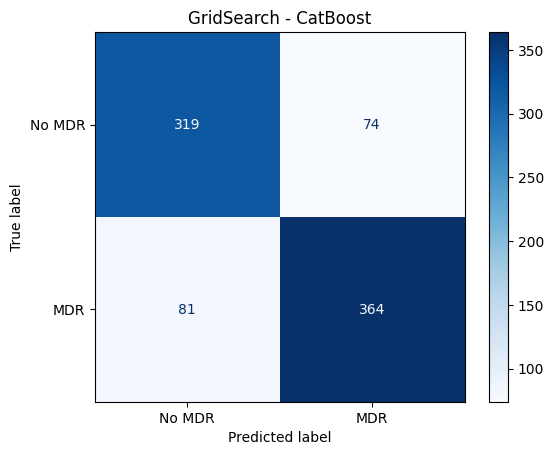


CatBoost - Training Accuracy: 0.8145
CatBoost - Testing Accuracy: 0.8150
CatBoost - Training F2: 0.8108
CatBoost - Testing F2: 0.8206
CatBoost - Best Params: {'clf__depth': 3, 'clf__iterations': 50, 'clf__learning_rate': 0.01}
CatBoost - Training Time: 9.91 seconds
CatBoost - Training Time: 9.91 seconds


In [37]:
# Loop through each model and perform GridSearchCV
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Create the pipeline
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('clf', model)
    ])
    
    # Create GridSearchCV with recall as the scoring metric
    grid_search = GridSearchCV(pipeline, param_grid=recall_grids[name], scoring='recall', cv=5, n_jobs=-1, verbose=1)
    
    # Track runtime
    start_time = time.time()
    
    # Fit the model with GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Track runtime
    end_time = time.time()
    runtime = end_time - start_time
    
    # Get the best model from GridSearchCV
    best_pipeline = grid_search.best_estimator_
    
    # Predict and get probabilities
    y_train_pred = best_pipeline.predict(X_train)
    y_test_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]

    # Confusion matrix and cost calculation
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics
    results_gridrecall[name] = {
        'train_accuracy': best_pipeline.score(X_train, y_train),
        'test_accuracy': best_pipeline.score(X_test, y_test),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'f2': fbeta_score(y_test, y_test_pred, beta=2),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'pr_auc': average_precision_score(y_test, y_proba),
        'CM': cm,
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'train_f2': fbeta_score(y_train, y_train_pred, beta=2),
        'test_f2': fbeta_score(y_test, y_test_pred, beta=2),
        'runtime': runtime,
        'best_params': grid_search.best_params_  # Save best hyperparameters
    }

    # Save the best model
    best_models_gridrecall[name] = best_pipeline
    joblib.dump(best_pipeline, f"saved_models/{name}_gridsearch_recall.pkl")

    # Display confusion matrix plot
    disp = ConfusionMatrixDisplay(cm, display_labels=['No MDR', 'MDR'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"GridSearch - {name}")
    plt.show()

    # Display metrics
    print(f"\n{name} - Training Accuracy: {results_gridrecall[name]['train_accuracy']:.4f}")
    print(f"{name} - Testing Accuracy: {results_gridrecall[name]['test_accuracy']:.4f}")
    print(f"{name} - Training F2: {results_gridrecall[name]['train_f2']:.4f}")
    print(f"{name} - Testing F2: {results_gridrecall[name]['test_f2']:.4f}")
    print(f"{name} - Best Params: {results_gridrecall[name]['best_params']}")
    print(f"{name} - Training Time: {runtime:.2f} seconds")
    
    
    # Runtime for model training
    print(f"{name} - Training Time: {runtime:.2f} seconds")

In [38]:
# Save results as a DataFrame to CSV sorted by F2 score
results_gridrecall_df = pd.DataFrame(results_gridrecall).T.sort_values(by='recall', ascending=False)
results_gridrecall_df.to_csv("saved_models/results_gridrecall.csv")

# Optionally, print results to see the sorted F2 score
print("\nResults sorted by recall score:")
print(results_gridrecall_df)


Results sorted by recall score:
                    train_accuracy test_accuracy precision    recall  \
Logistic Regression        0.80675      0.806683  0.808279  0.833708   
XGBoost                   0.817503      0.804296  0.808791  0.826966   
LightGBM                  0.817503      0.804296  0.808791  0.826966   
Decision Tree             0.814516      0.815036   0.83105  0.817978   
CatBoost                  0.814516      0.815036   0.83105  0.817978   
Random Forest             0.819594      0.817422  0.842723  0.806742   

                           f1        f2   roc_auc    pr_auc  \
Logistic Regression  0.820796  0.828495  0.874698  0.892959   
XGBoost              0.817778  0.823266  0.890108  0.910348   
LightGBM             0.817778  0.823266  0.890408  0.908557   
Decision Tree        0.824462  0.820559  0.881611  0.897874   
CatBoost             0.824462  0.820559   0.87577  0.901059   
Random Forest         0.82434   0.81369  0.890342  0.906123   

                    

From these results, **Logistic Regression achieved the highest recall (83.4%)**, making it the most effective at minimizing false negatives, while XGBoost and LightGBM followed closely with ~82.7%. Decision Tree, CatBoost, and Random Forest showed slightly lower recall, but all models delivered fairly comparable performance overall.

# Best Models

In [39]:
# Summary Outputs 
print("\nTop Models (No GridSearch):")
print(results_df_nogrid[['recall', 'precision', 'test_f1', 'test_f2', 'roc_auc', 'pr_auc' ]])

print("\nTop Models (GridSearch F2):")
print(results_gridF2_df[['best_params']])
print(results_gridF2_df[['recall', 'precision', 'test_f1', 'test_f2', 'roc_auc', 'pr_auc' ]])

print("\nTop Models (GridSearch Recall):")
print(results_gridrecall_df[['best_params']])
print(results_gridrecall_df[['recall', 'precision', 'test_f1', 'test_f2', 'roc_auc', 'pr_auc' ]])


Top Models (No GridSearch):
                       recall precision   test_f1   test_f2   roc_auc  \
Logistic Regression  0.833708  0.808279  0.820796  0.828495    0.8746   
Random Forest        0.806742  0.842723   0.82434   0.81369  0.890337   
LightGBM             0.802247      0.85  0.825434  0.811364  0.890983   
Decision Tree        0.802247  0.847981   0.82448  0.810995  0.888853   
XGBoost              0.802247  0.847981   0.82448  0.810995  0.890468   
CatBoost             0.802247  0.847981   0.82448  0.810995  0.890622   

                       pr_auc  
Logistic Regression  0.892724  
Random Forest        0.906569  
LightGBM             0.910873  
Decision Tree        0.902865  
XGBoost              0.910268  
CatBoost             0.910724  

Top Models (GridSearch F2):
                                                           best_params
XGBoost              {'clf__learning_rate': 0.001, 'clf__max_depth'...
Logistic Regression              {'clf__C': 0.1, 'clf__penalty':


---

## Top Models (No GridSearch)


| Model                | Recall  | Precision | Test F1  | Test F2  | ROC AUC | PR AUC  |
|-----------------------|---------|-----------|----------|----------|---------|---------|
| **Logistic Regression** | **0.834** | 0.808     | 0.821    | 0.828    | 0.875   | 0.893   |
| Random Forest         | 0.807   | 0.843     | 0.824    | 0.814    | 0.890   | 0.907   |
| LightGBM              | 0.802   | **0.850** | 0.825    | 0.811    | **0.891** | **0.911** |
| Decision Tree         | 0.802   | 0.848     | 0.824    | 0.811    | 0.889   | 0.903   |
| XGBoost               | 0.802   | 0.848     | 0.824    | 0.811    | 0.890   | 0.910   |
| CatBoost              | 0.802   | 0.848     | 0.824    | 0.811    | 0.891   | 0.911   |


---

## Top Models (GridSearch F₂)


| Model                | Recall  | Precision | Test F1  | Test F2  | ROC AUC | PR AUC  |
|-----------------------|---------|-----------|----------|----------|---------|---------|
| **XGBoost**           | **0.935** | 0.675     | 0.784    | **0.868** | 0.888   | 0.900   |
| Logistic Regression   | 0.834   | 0.808     | 0.821    | 0.828    | 0.875   | 0.893   |
| LightGBM              | 0.827   | 0.809     | 0.818    | 0.823    | **0.890** | **0.909** |
| Decision Tree         | 0.818   | 0.831     | 0.824    | 0.821    | 0.882   | 0.898   |
| CatBoost              | 0.818   | 0.831     | 0.824    | 0.821    | 0.876   | 0.901   |
| Random Forest         | 0.807   | **0.843** | 0.824    | 0.814    | 0.890   | 0.906   |


---

## Top Models (GridSearch Recall)


| Model                | Recall  | Precision | Test F1  | Test F2  | ROC AUC | PR AUC  |
|-----------------------|---------|-----------|----------|----------|---------|---------|
| **Logistic Regression** | **0.834** | 0.808     | 0.821    | 0.828    | 0.875   | 0.893   |
| XGBoost               | 0.827   | 0.809     | 0.818    | 0.823    | 0.890   | **0.910** |
| LightGBM              | 0.827   | 0.809     | 0.818    | 0.823    | **0.890** | 0.909   |
| Decision Tree         | 0.818   | 0.831     | 0.824    | 0.821    | 0.882   | 0.898   |
| CatBoost              | 0.818   | 0.831     | 0.824    | 0.821    | 0.876   | 0.901   |
| Random Forest         | 0.807   | **0.843** | 0.824    | 0.814    | 0.890   | 0.906   |


---

## Key Insights

1. **Best Recall (minimizing false negatives):**

   * **XGBoost (GridSearch F₂)** → Recall **0.935**, F₂ **0.868**.
   * This is the clear winner if catching **every MDR case** is the priority, but its precision (0.675) is the lowest → more false positives.

2. **Best Balanced Model:**

   * **Logistic Regression** → Recall \~**0.834**, Precision \~0.808, F₂ \~0.828.
   * Consistent across baseline and GridSearch.
   * Strong balance: fewer false negatives than trees/ensembles, but without overwhelming false positives like XGBoost.

---

We decided to move on with the recall optimized LogReg since it is the most balanced overall.





# Threshold Tuning

In [ ]:
# Get the best Logistic Regression model from grid search recall optimized
best_logreg = best_models_gridrecall["Logistic Regression"]

In [41]:
# Split training set into train/validation for threshold search
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Refit on X_tr so test set stays untouched
best_logreg.fit(X_tr, y_tr)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['abruse']),
                                                 ('binary',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('passthrough',
                                                                   'passthrough')]),
                                                  ['boil_milk',
                                                   'diseased_animals_eaten',
                                                   'education']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['milk_consume'])])),
                ('clf',
                 LogisticRegression(C=0.1, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [42]:
# Find threshold that maximizes F2 on validation
p_val = best_logreg.predict_proba(X_val)[:, 1]
ts = np.linspace(0.10, 0.90, 17)
best_t, best_f2 = 0.5, -1
for t in ts:
    yv = (p_val >= t).astype(int)
    f2 = fbeta_score(y_val, yv, beta=2)
    if f2 > best_f2:
        best_t, best_f2 = t, f2

print(f"\n[Logistic Regression] Best threshold by F2: t={best_t:.2f}, F2={best_f2:.4f}")


[Logistic Regression] Best threshold by F2: t=0.20, F2=0.8797


In [43]:
# Evaluate on TEST at tuned threshold and default 0.5
p_test = best_logreg.predict_proba(X_test)[:, 1]

def report(y_true, proba, t, label):
    yp = (proba >= t).astype(int)
    cm = confusion_matrix(y_true, yp)
    print(f"\n=== {label} @ t={t:.2f} ===")
    print(f"precision: {precision_score(y_true, yp):.4f}")
    print(f"   recall: {recall_score(y_true, yp):.4f}")
    print(f"       f1: {f1_score(y_true, yp):.4f}")
    print(f"       f2: {fbeta_score(y_true, yp, beta=2):.4f}")
    print(f"  roc_auc: {roc_auc_score(y_true, proba):.4f}")
    print(f"   pr_auc: {average_precision_score(y_true, proba):.4f}")
    print("CM [[TN, FP], [FN, TP]]:", cm.tolist())

report(y_test, p_test, best_t, "LogReg (threshold tuned)")
report(y_test, p_test, 0.50, "LogReg (default 0.5)")


=== LogReg (threshold tuned) @ t=0.20 ===
precision: 0.6224
   recall: 0.9596
       f1: 0.7551
       f2: 0.8658
  roc_auc: 0.8746
   pr_auc: 0.8925
CM [[TN, FP], [FN, TP]]: [[134, 259], [18, 427]]

=== LogReg (default 0.5) @ t=0.50 ===
precision: 0.8083
   recall: 0.8337
       f1: 0.8208
       f2: 0.8285
  roc_auc: 0.8746
   pr_auc: 0.8925
CM [[TN, FP], [FN, TP]]: [[305, 88], [74, 371]]


In [53]:
# Sweep thresholds from 0.30 to 0.50 with step 0.01
results = []
for t in np.arange(0.20, 0.51, 0.01):
    p = best_logreg.predict_proba(X_test)[:, 1]
    yhat = (p >= t).astype(int)
    prec = precision_score(y_test, yhat, zero_division=0)
    rec  = recall_score(y_test, yhat)
    f2   = fbeta_score(y_test, yhat, beta=2)
    cm   = confusion_matrix(y_test, yhat).tolist()
    results.append({
        "threshold": round(t, 2),
        "precision": round(prec, 4),
        "recall": round(rec, 4),
        "f2": round(f2, 4),
        "cm": cm
    })

# Turn into DataFrame for nice viewing
import pandas as pd
df_thr = pd.DataFrame(results)
print(df_thr)


    threshold  precision  recall      f2                       cm
0        0.20     0.6224  0.9596  0.8658  [[134, 259], [18, 427]]
1        0.21     0.6377  0.9416  0.8597  [[155, 238], [26, 419]]
2        0.22     0.6377  0.9416  0.8597  [[155, 238], [26, 419]]
3        0.23     0.6377  0.9416  0.8597  [[155, 238], [26, 419]]
4        0.24     0.6387  0.9416  0.8600  [[156, 237], [26, 419]]
5        0.25     0.6466  0.9416  0.8629  [[164, 229], [26, 419]]
6        0.26     0.6583  0.9393  0.8654  [[176, 217], [27, 418]]
7        0.27     0.6792  0.9326  0.8678  [[197, 196], [30, 415]]
8        0.28     0.7019  0.8944  0.8479  [[224, 169], [47, 398]]
9        0.29     0.7019  0.8944  0.8479  [[224, 169], [47, 398]]
10       0.30     0.7132  0.8831  0.8430  [[235, 158], [52, 393]]
11       0.31     0.7204  0.8742  0.8384  [[242, 151], [56, 389]]
12       0.32     0.7311  0.8674  0.8362  [[251, 142], [59, 386]]
13       0.33     0.7311  0.8674  0.8362  [[251, 142], [59, 386]]
14       0

For the remainder of this project, we adopt Logistic Regression with a threshold of 0.38 as the primary model. This setting provides the best balance for our goals: high recall (86.3%) to minimize false negatives, while keeping precision (75.7%) at a reasonable level.

In [55]:
# Bundle model + threshold in one dictionary
package = {
    "model": best_logreg,   # your trained pipeline
    "threshold": 0.38       # chosen cutoff
}

joblib.dump(package, "saved_models/LogReg_with_threshold_038.pkl")

['saved_models/LogReg_with_threshold_038.pkl']

# Feature Importance & SHAP

## Feature Importance

In [56]:
# Load the bundle
package = joblib.load("saved_models/LogReg_with_threshold_038.pkl")
logreg = package["model"]

In [57]:
# Get feature names from your preprocessor
feature_names = logreg.named_steps["preprocessing"].get_feature_names_out()

# Get coefficients from the logistic regression model
coefs = logreg.named_steps["clf"].coef_[0]

In [58]:
# Put into a DataFrame for inspection
feat_importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_importance": np.abs(coefs)
}).sort_values(by="abs_importance", ascending=False)

print(feat_importance.head(15))

                          feature  coefficient  abs_importance
1               binary__boil_milk    -2.404217        2.404217
4               num__milk_consume     1.431183        1.431183
2  binary__diseased_animals_eaten     0.735590        0.735590
3               binary__education     0.119954        0.119954
0                 ordinal__abruse     0.053747        0.053747


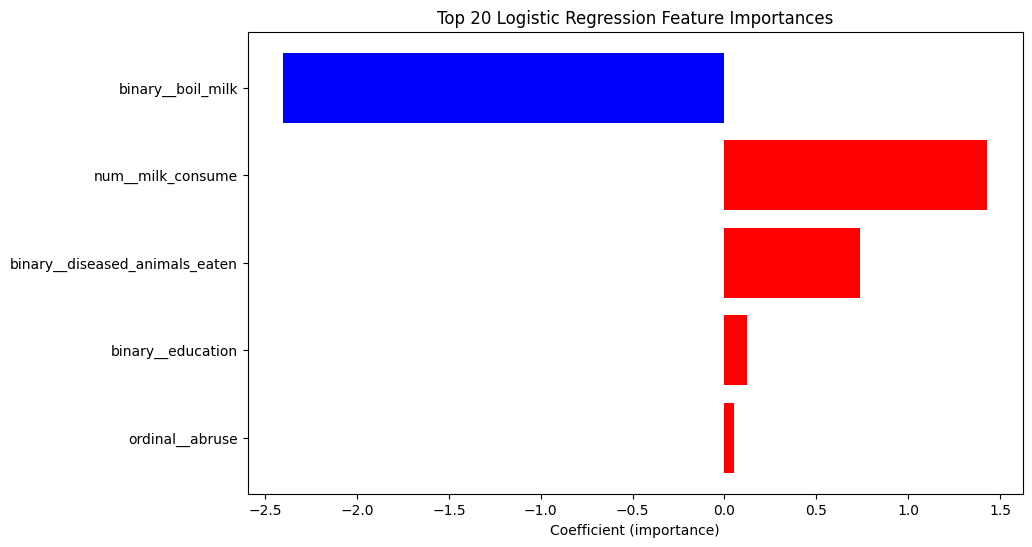

In [ ]:
# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_importance["feature"][:5][::-1],  # top 5, reversed for nice plot
         feat_importance["coefficient"][:5][::-1],
         color=["blue" if c < 0 else "red" for c in feat_importance["coefficient"][:5][::-1]])
plt.xlabel("Coefficient (importance)")
plt.title("Top 5 Logistic Regression Feature Importances")
plt.show()

The model shows that **boiling milk strongly reduces MDR risk** (protective factor), while **milk consumption and eating diseased animals increase MDR risk**. **Education has a small protective effect**, and **antibiotic use (abruse)** contributes only minimally.

## SHAP

In [ ]:
# SHAP for Logistic Regression
explainer = shap.LinearExplainer(logreg.named_steps["clf"],
                                 logreg.named_steps["preprocessing"].transform(X_train),
                                 feature_names=feature_names)

In [ ]:
# Explain test predictions
shap_values = explainer.shap_values(logreg.named_steps["preprocessing"].transform(X_test))

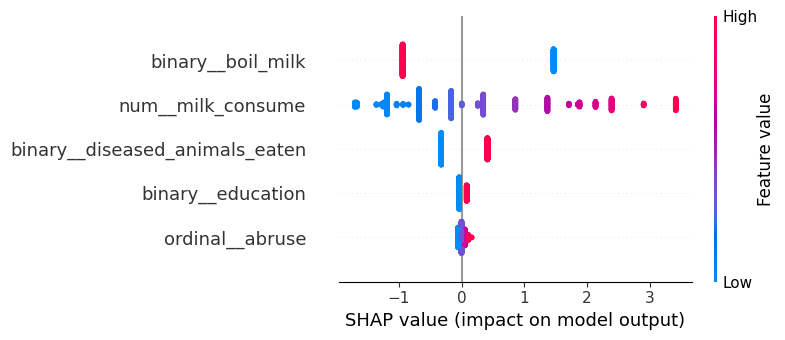

In [60]:
# Summary plot (global importance)
shap.summary_plot(shap_values, features=logreg.named_steps["preprocessing"].transform(X_test), 
                  feature_names=feature_names)

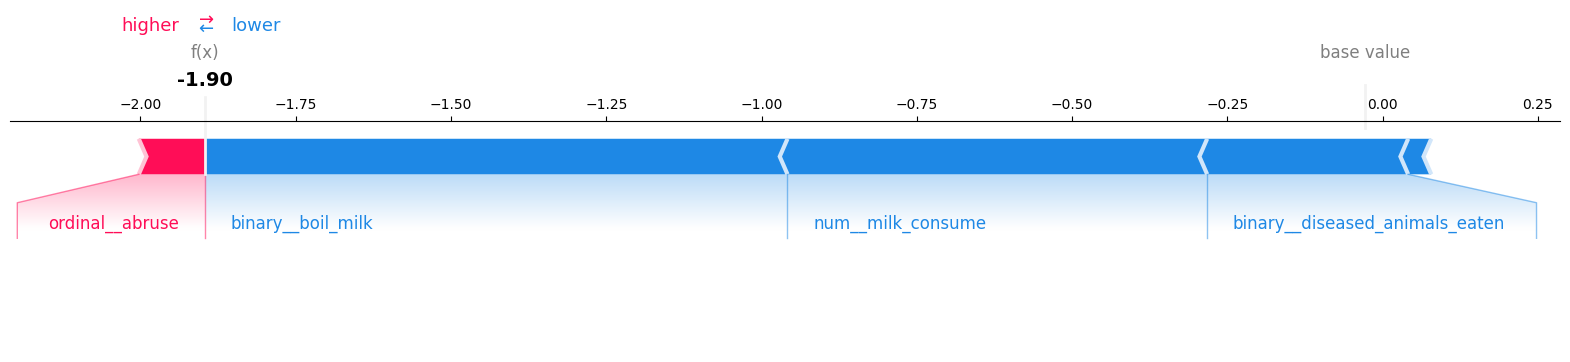

In [61]:
# Force plot (one example, local explanation)
shap.force_plot(explainer.expected_value, shap_values[0,:], 
                feature_names=feature_names, matplotlib=True)

The SHAP results show that boiling milk protects against MDR, while higher milk consumption and eating diseased animals increase MDR risk. Education offers a slight protective effect, and antibiotic use contributes very little to the predictions.

# Conclusion

## Key Findings

1. **Model Performance – Logistic Regression (Threshold = 0.38)**

   * The model achieved a **recall of 86.3%**, meaning it successfully identified most MDR cases and kept false negatives relatively low.
   * **Precision was 75.7%**, so about three-quarters of the cases predicted as MDR were correct. While there are still some false positives, this trade-off is acceptable since the main priority is avoiding missed cases.
   * The **F₂ score was 0.84**, showing a good balance with stronger weight on recall.
   * Both **ROC-AUC (\~0.875)** and **PR-AUC (\~0.893)** indicate that the model separates MDR from non-MDR cases well, even with imbalanced data.

*Other models like XGBoost, LightGBM, CatBoost, and Random Forest were also tested. Some reached higher recall during grid search but created too many false positives. Logistic Regression with threshold tuning gave the best mix of performance, simplicity, and interpretability.*

---

2. **Confusion Matrix (t = 0.38)**

   * **61 MDR cases were missed** (false negatives). These are the most concerning errors.
   * **123 non-MDR cases were incorrectly flagged** (false positives). While not ideal, these are less harmful than missing true MDR cases.

---

3. **Important Predictors**

   * **Milk consumption** was linked with a higher chance of MDR.
   * **Boiling milk** showed a protective effect, lowering MDR risk.
   * **Eating diseased animals** increased MDR risk.
   * **Education level** provided a slight protective effect.
   * **Antibiotic use** had only a minor impact.

---

4. **Recommendations**

   * Encourage **boiling milk before drinking** and discourage consumption of diseased animals.
   * Support **community health education** around food safety and AMR awareness, especially in lower-education groups.
   * Test this approach on **larger and more diverse datasets** to confirm findings and strengthen public health recommendations.
   * Pilot-test the model in **community settings** to evaluate real-world impact. 
   * Use predictions to guide **targeted AMRand MDR education campaigns** and household-level interventions.

# Future Enhancements (With More Time & Resources)

If time and technical resources had permitted, the following would have been pursued:

* **Expand Dataset**

  * Collect data from **more regions and larger samples** to improve generalizability.
  * Include additional household, environmental, and socio-economic variables.

* **Model Refinement**

  * Experiment with **advanced ensemble methods** or hybrid approaches for further performance gains.
  * Fine-tune thresholds dynamically based on **different public health priorities** (e.g., safety-net mode vs. balanced mode).

* **Interpretability & Communication**

  * Build **interactive dashboards** to visualize risk factors and model predictions for policymakers and health workers.
